# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Essential Imports for the Project
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # For enhanced data visualizations
import torch  # PyTorch library for deep learning
from torch import nn, optim, tensor  # Neural network and optimization tools
import torch.nn.functional as F  # For activation functions
from torch.autograd import Variable  # Handles tensor gradients
from torchvision import datasets, transforms, models  # For datasets, transformations, and pre-trained models
from PIL import Image  # For image processing
import argparse  # For command-line argument parsing
from collections import OrderedDict  # For maintaining the order of dictionary elements
import json  # For working with JSON data (e.g., category mappings)
import time  # For tracking execution time

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
# Define Data Directories
data_dir = 'flowers'  # Main directory containing the dataset
train_dir = f"{data_dir}/train"  # Directory for training data
valid_dir = f"{data_dir}/valid"  # Directory for validation data
test_dir = f"{data_dir}/test"    # Directory for test data

In [6]:
# Define Data Transformations
# Training transformations include random resizing and flipping for data augmentation.
# Validation and testing transformations only resize and crop for consistency with pre-trained models.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224),  # Randomly crop images to 224x224
        transforms.RandomHorizontalFlip(),       # Randomly flip images horizontally
        transforms.ToTensor(),                   # Convert images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize channels
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),             # Resize images to 256x256
        transforms.CenterCrop(size=224),         # Crop the center to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load Datasets Using ImageFolder
# ImageFolder automatically associates classes with folders and applies the transformations.
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Define DataLoaders
# DataLoaders are used to iterate through datasets in batches.
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)

# Get Sizes of DataLoaders
# Useful for calculating average loss and accuracy.
train_loader_size = len(train_loader)
validation_loader_size = len(validation_loader)
test_loader_size = len(test_loader)

# Print Sizes of Training, Validation, and Test Sets
print(f"Training Set Size: {train_loader_size}")
print(f"Validation Set Size: {validation_loader_size}")
print(f"Test Set Size: {test_loader_size}")


Training Set Size: 103
Validation Set Size: 13
Test Set Size: 13


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as file:
    cat_to_name = json.load(file)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# Build and Train the Neural Network

# Load Pretrained VGG16 Model
# VGG16 is a popular pre-trained model with many parameters, making it large and memory-intensive,
# but its pre-trained weights provide a strong starting point for image classification tasks.
# Source: https://forums.fast.ai/t/vgg-strength-and-limitations/1218
model = models.vgg16(pretrained=True)

# Freeze the Pre-trained Layers
# By default, PyTorch tracks changes to parameters for backpropagation, increasing memory usage.
# Since we don't need to retrain the pre-trained layers, we'll freeze them to save resources.
for param in model.parameters():
    param.requires_grad = False

# Customize the Classifier
# Replace the final layer of VGG16 with a custom Sequential classifier for our specific task.
# We use `OrderedDict` to ensure the layers are added in order.
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('inputs', nn.Linear(25088, 120)),  # Input layer connected to VGG16's feature output
    ('relu1', nn.ReLU()),               # First activation function
    ('dropout', nn.Dropout(0.5)),       # Dropout for regularization (50% probability)
    ('hidden_layer1', nn.Linear(120, 90)),  # Hidden layer 1
    ('relu2', nn.ReLU()),                   # Activation for hidden layer 1
    ('hidden_layer2', nn.Linear(90, 70)),   # Hidden layer 2
    ('relu3', nn.ReLU()),                   # Activation for hidden layer 2
    ('hidden_layer3', nn.Linear(70, 102)),  # Final layer with 102 output classes
    ('output', nn.LogSoftmax(dim=1))        # Log-Softmax for multi-class classification
]))

model.classifier = classifier

# Prepare the Model for GPU (if available)
if torch.cuda.is_available():
    model.cuda()
    print("Model moved to GPU.")
else:
    print("GPU not available, using CPU.")

# Define the Loss Function and Optimizer
# Negative Log Likelihood Loss is suitable for multi-class classification.
# Adam optimizer is chosen for its adaptive learning rate capabilities.
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("Model and training setup is ready!")


c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Yasamin/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:33<00:00, 5.95MB/s] 


GPU not available, using CPU.
Model and training setup is ready!


In [13]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Check the CUDA version PyTorch is built with


False
None


In [12]:
# Import required libraries
import torch

# Automatically choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Update the training loop
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    
    # Set the model to training mode
    model.train()
    
    # Initialize loss and accuracy tracking for the epoch
    train_loss = 0.0
    train_acc = 0.0
    
    for batch_index, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the selected device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Clear any previously accumulated gradients
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = model(inputs)
        
        # Compute loss for the current batch
        loss = criterion(outputs, labels)
        
        # Backpropagate the loss to compute gradients
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Update total loss for the current batch
        train_loss += loss.item() * inputs.size(0)
        
        # Compute accuracy for the current batch
        _, predictions = torch.max(outputs.data, 1)  # Get predicted class
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert to float for averaging and compute accuracy
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * inputs.size(0)
        
        # Print training status for the current batch
        print(f"Batch {batch_index + 1:03d}, Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

# At the end of training
print("Training complete!")


Using device: cpu
Epoch: 1/18
Batch 001, Loss: 4.6111, Accuracy: 0.0000
Batch 002, Loss: 4.6285, Accuracy: 0.0312
Batch 003, Loss: 4.5872, Accuracy: 0.0312
Batch 004, Loss: 4.6188, Accuracy: 0.0312
Batch 005, Loss: 4.6354, Accuracy: 0.0156
Batch 006, Loss: 4.5751, Accuracy: 0.0156
Batch 007, Loss: 4.5646, Accuracy: 0.0000
Batch 008, Loss: 4.5645, Accuracy: 0.0469
Batch 009, Loss: 4.6512, Accuracy: 0.0312
Batch 010, Loss: 4.5936, Accuracy: 0.0469
Batch 011, Loss: 4.6173, Accuracy: 0.0000
Batch 012, Loss: 4.5342, Accuracy: 0.0625
Batch 013, Loss: 4.4855, Accuracy: 0.0625
Batch 014, Loss: 4.5329, Accuracy: 0.0625
Batch 015, Loss: 4.4627, Accuracy: 0.0469
Batch 016, Loss: 4.3306, Accuracy: 0.0938
Batch 017, Loss: 4.3331, Accuracy: 0.1250
Batch 018, Loss: 4.3439, Accuracy: 0.0625
Batch 019, Loss: 4.8515, Accuracy: 0.0156
Batch 020, Loss: 4.5120, Accuracy: 0.0625
Batch 021, Loss: 4.5596, Accuracy: 0.0312
Batch 022, Loss: 4.4812, Accuracy: 0.1094
Batch 023, Loss: 4.3926, Accuracy: 0.0938
Batc

In [14]:
# Perform validation to evaluate model performance on the validation set
with torch.no_grad():
    
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()
    
    # Initialize validation loss and accuracy
    valid_loss = 0.0
    valid_acc = 0.0
    
    # Validation loop
    for batch_index, (inputs, labels) in enumerate(validation_loader):
        # Move inputs and labels to the selected device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass: compute predictions
        outputs = model(inputs)
        
        # Compute loss for the current batch
        loss = criterion(outputs, labels)
        
        # Add the loss for the batch to the total validation loss
        valid_loss += loss.item() * inputs.size(0)
        
        # Compute validation accuracy
        _, predictions = torch.max(outputs.data, 1)  # Get predicted class
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert to float for averaging and compute accuracy
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        valid_acc += acc.item() * inputs.size(0)
        
        # Print validation status for the current batch
        print(f"Validation Batch {batch_index + 1:03d}: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")
    
    # Calculate average loss and accuracy over the entire validation set
    avg_valid_loss = valid_loss / len(validation_loader.dataset)
    avg_valid_acc = valid_acc / len(validation_loader.dataset)
    
    print(f"Validation Complete: Avg Loss: {avg_valid_loss:.4f}, Avg Accuracy: {avg_valid_acc:.4f}")


Validation Batch 001: Loss: 0.4712, Accuracy: 0.8594
Validation Batch 002: Loss: 0.5961, Accuracy: 0.8125
Validation Batch 003: Loss: 0.3886, Accuracy: 0.9062
Validation Batch 004: Loss: 0.7294, Accuracy: 0.8281
Validation Batch 005: Loss: 0.5786, Accuracy: 0.8125
Validation Batch 006: Loss: 0.4139, Accuracy: 0.8750
Validation Batch 007: Loss: 0.6587, Accuracy: 0.8750
Validation Batch 008: Loss: 0.7298, Accuracy: 0.8906
Validation Batch 009: Loss: 0.4970, Accuracy: 0.8281
Validation Batch 010: Loss: 0.6388, Accuracy: 0.8281
Validation Batch 011: Loss: 0.7263, Accuracy: 0.7812
Validation Batch 012: Loss: 0.5789, Accuracy: 0.8281
Validation Batch 013: Loss: 0.4423, Accuracy: 0.8800
Validation Complete: Avg Loss: 0.5753, Avg Accuracy: 0.8460


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# Perform validation on the test set
correct, total = 0, 0
with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()
    
    # Loop through the test loader
    for images, labels in test_loader:
        # Move images and labels to the selected device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass to get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        
        # Update total samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print overall test set accuracy
test_accuracy = 100 * correct / total
print(f'Accuracy on test images: {test_accuracy:.2f}%')


Accuracy on test images: 82.05%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
# Save the trained model checkpoint

# Attach the mapping of class indices to class names to the model
model.class_to_idx = image_datasets['train'].class_to_idx

# Save the model checkpoint using torch.save
checkpoint = {
    'architecture': 'vgg16',  # Specify the architecture used (e.g., 'vgg16', 'alexnet', etc.)
    'hidden_layer1': 120,     # Number of neurons in the first hidden layer
    'dropout': 0.5,           # Dropout probability
    'epochs': epochs,         # Number of training epochs
    'state_dict': model.state_dict(),  # Save the model's learned parameters (weights)
    'class_to_idx': model.class_to_idx,  # Save the class-to-index mapping
    'optimizer_dict': optimizer.state_dict()  # Save the optimizer's state
}

# Save the checkpoint to a file
torch.save(checkpoint, 'checkpoint.pth')

print("Checkpoint saved successfully as 'checkpoint.pth'")


Checkpoint saved successfully as 'checkpoint.pth'


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [20]:
def load_checkpoint(filepath='checkpoint.pth'):
    """
    Load a saved model checkpoint and rebuild the model with a custom classifier.
    Args:
        filepath (str): Path to the checkpoint file
    Returns:
        model (torch.nn.Module): Rebuilt model with loaded state_dict
    """
    try:
        print(f"Attempting to load checkpoint from: {filepath}")
        # Load the checkpoint file
        checkpoint = torch.load(filepath)
        print("Checkpoint loaded successfully!")

        # Load the pretrained VGG16 model
        model = models.vgg16(pretrained=True)
        model.name = "vgg16"
        print(f"Using pre-trained model: {model.name}")

        # Freeze model parameters
        for param in model.parameters():
            param.requires_grad = False

        # Rebuild the custom classifier
        from collections import OrderedDict
        classifier = nn.Sequential(OrderedDict([
            ('inputs', nn.Linear(25088, 120)),
            ('relu1', nn.ReLU()),
            ('dropout', nn.Dropout(0.5)),
            ('hidden_layer1', nn.Linear(120, 90)),
            ('relu2', nn.ReLU()),
            ('hidden_layer2', nn.Linear(90, 70)),
            ('relu3', nn.ReLU()),
            ('hidden_layer3', nn.Linear(70, 102)),
            ('output', nn.LogSoftmax(dim=1))
        ]))
        model.classifier = classifier
        print("Custom classifier rebuilt.")

        # Load the state dictionary into the model
        model.load_state_dict(checkpoint['state_dict'])
        print("Model state dictionary loaded.")

        # Load class-to-index mapping
        model.class_to_idx = checkpoint['class_to_idx']
        print(f"Class-to-index mapping loaded: {model.class_to_idx}")

        print("Checkpoint loaded successfully from:", filepath)
        return model
    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {filepath}. Please verify the path.")
    except KeyError as e:
        print(f"Error in loading checkpoint. Missing key: {e}")
    except Exception as e:
        print(f"An error occurred while loading the checkpoint: {e}")

# Example usage
model = load_checkpoint('checkpoint.pth')
if model:
    print("Model is ready for use!")
else:
    print("Failed to load model.")


Attempting to load checkpoint from: checkpoint.pth
Checkpoint loaded successfully!
Using pre-trained model: vgg16
Custom classifier rebuilt.
Model state dictionary loaded.
Class-to-index mapping loaded: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:
from PIL import Image
import numpy as np

def process_image(image_path):
    """
    Scales, crops, and normalizes a PIL image for use in a PyTorch model.
    Args:
        image_path (str): Path to the image file.
    Returns:
        numpy.ndarray: Processed image as a NumPy array.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Resize the image to maintain aspect ratio but scale the shortest side to 256 pixels
    img.thumbnail((256, 256))
    
    # Get the dimensions of the resized image
    width, height = img.size

    # Define coordinates to crop the center 224x224 square
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = left + 224
    bottom = top + 224
    img = img.crop((left, top, right, bottom))
    
    # Convert image to a NumPy array and normalize pixel values to [0, 1]
    np_image = np.array(img) / 255.0

    # Normalize each channel using mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Rearrange dimensions to PyTorch format (C x H x W)
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

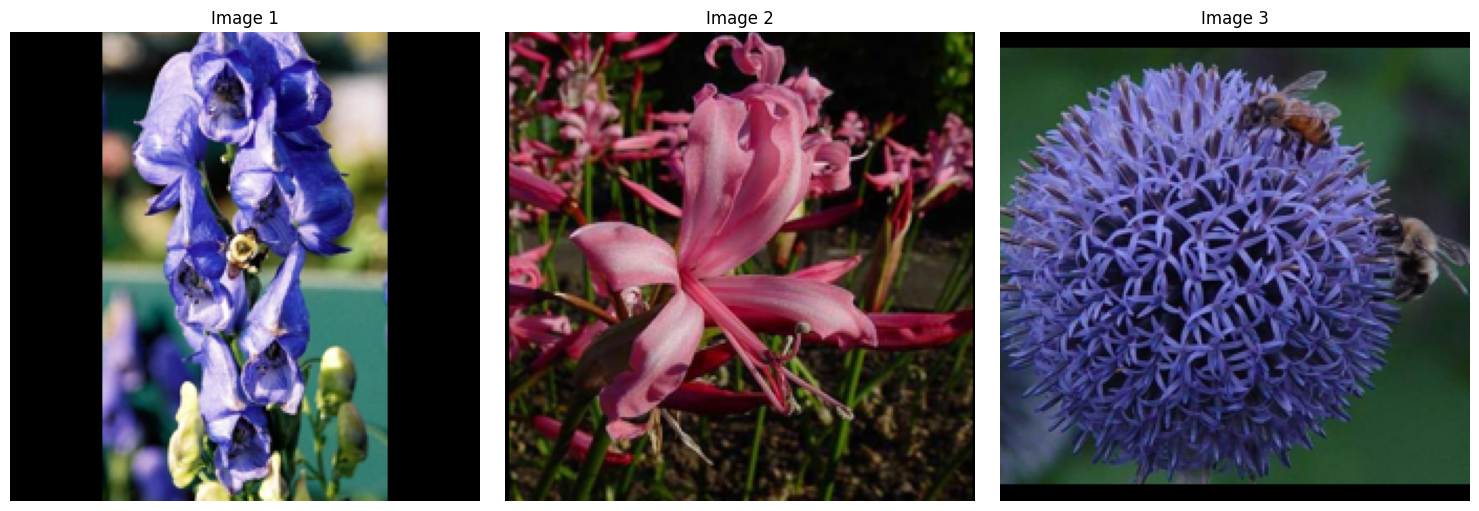

In [22]:
def imshow(image, ax=None, title=None):
    """
    Displays a processed PyTorch image in matplotlib.
    Args:
        image (numpy.ndarray): Processed image in (C x H x W) format.
        ax (matplotlib.axes.Axes, optional): Axis to plot the image. Defaults to None.
        title (str, optional): Title of the image. Defaults to None.
    Returns:
        matplotlib.axes.Axes: Axis with the image.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    if title:
        ax.set_title(title)
    
    # PyTorch tensors use (C x H x W), but Matplotlib expects (H x W x C)
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing (denormalize the image)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip pixel values to be between 0 and 1
    image = np.clip(image, 0, 1)
    
    # Display the image
    ax.imshow(image)
    ax.axis('off')  # Remove axes for better visualization
    
    return ax

# Example usage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
image_paths = [
    "flowers/test/9/image_06413.jpg",
    "flowers/test/37/image_03734.jpg",
    "flowers/test/10/image_07090.jpg"
]

for i, image_path in enumerate(image_paths):
    processed_image = process_image(image_path)
    imshow(processed_image, ax=axes[i], title=f"Image {i+1}")

plt.tight_layout()
plt.show()


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [23]:
def predict(image_path, model, top_k=5):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained PyTorch model for prediction.
        top_k (int): Number of top classes to return.

    Returns:
        tuple: top_probabilities, top_labels, top_flowers
    """
    # Ensure model is on CPU for prediction
    device = torch.device("cpu")
    model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Process the image and convert it to a PyTorch tensor
    processed_image = process_image(image_path)
    tensor_image = torch.from_numpy(np.expand_dims(processed_image, axis=0)).type(torch.FloatTensor).to(device)
    
    # Perform a forward pass through the model
    with torch.no_grad():
        log_probs = model.forward(tensor_image)
    
    # Convert log probabilities to actual probabilities
    probs = torch.exp(log_probs)
    
    # Get the top K probabilities and their corresponding indices
    top_probs, top_indices = probs.topk(top_k)
    
    # Detach tensors and convert to numpy arrays
    top_probs = top_probs.numpy().squeeze()
    top_indices = top_indices.numpy().squeeze()
    
    # Map indices to class labels
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[idx] for idx in top_indices]
    
    # Map class labels to flower names
    top_flowers = [cat_to_name[label] for label in top_labels]
    
    return top_probs, top_labels, top_flowers


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

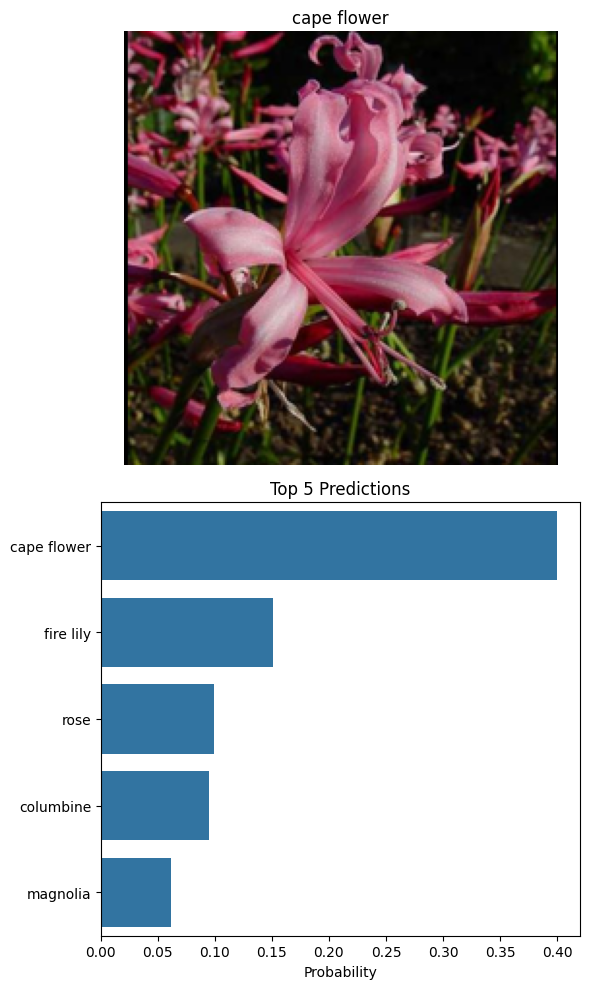

In [24]:
# TODO: Display an image along with the top 5 classes

# Define the image path
image_path = "flowers/test/37/image_03734.jpg"

# Set up the plot
plt.figure(figsize=(6, 10))
ax = plt.subplot(2, 1, 1)

# Extract flower number from the image path and get the corresponding name
flower_num = image_path.split('/')[-2]  # Adjusted to handle any file path separator
title_ = cat_to_name.get(flower_num, "Unknown Flower")

# Display the image with its title
img = process_image(image_path)
imshow(img, ax=ax, title=title_)

# Make predictions using the trained model
probs, labs, flowers = predict(image_path, model)

# Plot the probabilities as a horizontal bar chart
plt.subplot(2, 1, 2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0])
plt.xlabel("Probability")
plt.title("Top 5 Predictions")
plt.tight_layout()
plt.show()


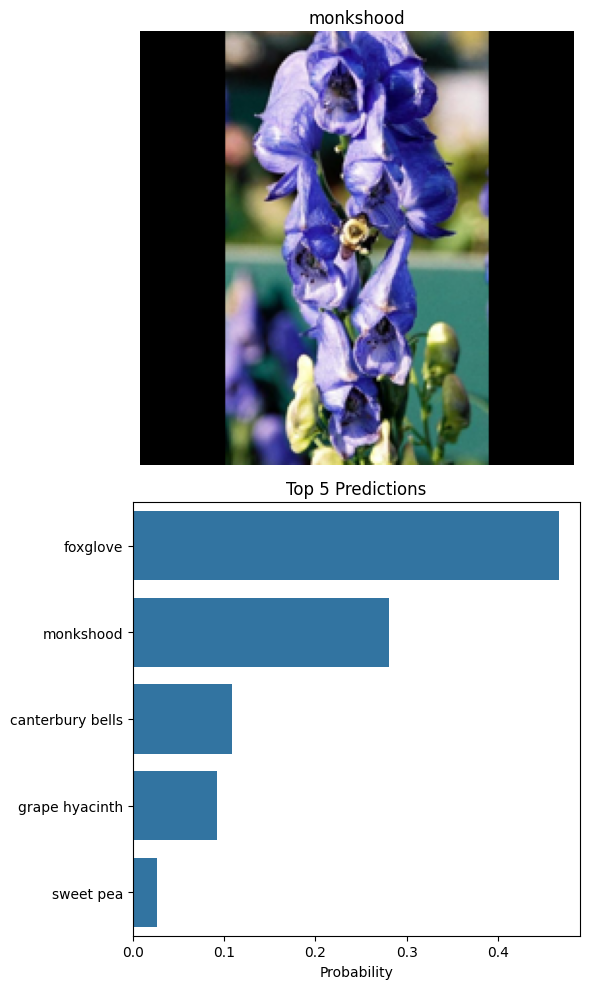

In [25]:
# Define the image path
image_path = "flowers/test/9/image_06413.jpg"

# Set up the plot
plt.figure(figsize=(6, 10))
ax = plt.subplot(2, 1, 1)

# Extract the flower number from the image path
flower_num = image_path.split('/')[-2]  # Adjust to handle different path separators
title_ = cat_to_name.get(flower_num, "Unknown Flower")  # Fallback if the flower_num isn't in cat_to_name

# Display the processed image with a title
img = process_image(image_path)
imshow(img, ax=ax, title=title_)

# Predict the top classes using the model
probs, labs, flowers = predict(image_path, model)

# Plot the bar chart for top probabilities
plt.subplot(2, 1, 2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0])
plt.xlabel("Probability")
plt.title("Top 5 Predictions")
plt.tight_layout()
plt.show()
